<a href="https://colab.research.google.com/github/VrindaBajaj20/ai-attack-snow3g-nea1/blob/main/experiments/nea1_rlppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install stable_baselines3

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt


In [38]:
print("Please upload the CSV file.")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

required_columns = ["COUNT", "Direction", "Bearer ID", "LENGTH", "KEY"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

Please upload the CSV file.


Saving snow3g_keystream (1).csv to snow3g_keystream (1) (4).csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [39]:
# Validate required columns
required_columns = ["KEY", "Direction", "LENGTH", "COUNT", "Bearer ID", "Keystream"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

In [40]:
# Convert binary string to numpy array of bits
def binstr_to_bits(bin_str):
    return np.array([int(b) for b in bin_str])

df['Keystream_bits'] = df['Keystream'].apply(binstr_to_bits)
df['Key_bits'] = df['KEY'].apply(lambda k: np.array([int(b) for b in bin(int(k,16))[2:].zfill(128)]))

# Stack into ML-ready arrays
X = np.stack(df['Keystream_bits'].values).astype(np.float32)
y = np.stack(df['Key_bits'].values).astype(np.int32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Preprocessing done. Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Preprocessing done. Shapes:
X_train: (80, 128) y_train: (80, 128)
X_test: (20, 128) y_test: (20, 128)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


#Defining VAE

In [41]:
input_dim = X_train.shape[1]
latent_dim = 32

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(64, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_h = Dense(64, activation='relu')
decoder_out = Dense(input_dim, activation='sigmoid')
outputs = decoder_out(decoder_h(z))

# KL Divergence layer
class KLLossLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
        self.add_loss(kl_loss)
        return z_mean

_ = KLLossLayer()([z_mean, z_log_var])

vae = Model(inputs, outputs)
vae.compile(optimizer='adam', loss='binary_crossentropy')
vae.fit(X_train, X_train, epochs=30, batch_size=64, validation_data=(X_test, X_test))


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 0.7460 - val_loss: 0.7419
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.7331 - val_loss: 0.7225
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.7202 - val_loss: 0.7273
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7180 - val_loss: 0.7222
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7130 - val_loss: 0.7217
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.7098 - val_loss: 0.7107
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.7080 - val_loss: 0.7081
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.7073 - val_loss: 0.7052
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7039 - val_loss: 0.7102
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.7040 - val_loss: 0.7069
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.7008 - val_loss: 0.7084
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.7025 - val_loss: 0.70

#latent representation

In [42]:
encoder = Model(inputs, z)
z_train = encoder.predict(X_train)
z_test = encoder.predict(X_test)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


#rl ppo

In [43]:
class SNOW3GEnv(gym.Env):
    def __init__(self, latent_vectors, keys):
        super(SNOW3GEnv, self).__init__()
        self.z = latent_vectors
        self.keys = keys
        self.index = 0
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(latent_vectors.shape[1],), dtype=np.float32
        )
        self.action_space = spaces.MultiBinary(128)  # NEA1 128-bit keystream block

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.index = np.random.randint(len(self.z))
        return self.z[self.index], {}

    def step(self, action):
        # Reward based on bitwise similarity to true keystream
        correct = 1 - np.mean(np.abs(action - self.keys[self.index]))
        done = True  # one-step episode
        return self.z[self.index], correct, done, False, {}


In [44]:
env = SNOW3GEnv(z_train, y_train)
check_env(env)


In [45]:
model = PPO("MlpPolicy", env, verbose=1, batch_size=64, n_steps=512)
model.learn(total_timesteps=50000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.495    |
| time/              |          |
|    fps             | 645      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 512      |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 0.506      |
| time/                   |            |
|    fps                  | 400        |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.06534349 |
|    clip_fraction        | 0.574      |
|    clip_range           | 0.2        |
|    entropy_loss         | -88.7

#ppo performance

In [46]:
correct_bits = []
for i in range(len(z_test)):
    obs = z_test[i]
    pred, _ = model.predict(obs, deterministic=True)
    correct = 1 - np.mean(np.abs(pred - y_test[i]))
    correct_bits.append(correct)

print(f"Final Bitwise Accuracy (VAE + PPO): {np.mean(correct_bits) * 100:.2f}%")


Final Bitwise Accuracy (VAE + PPO): 49.26%


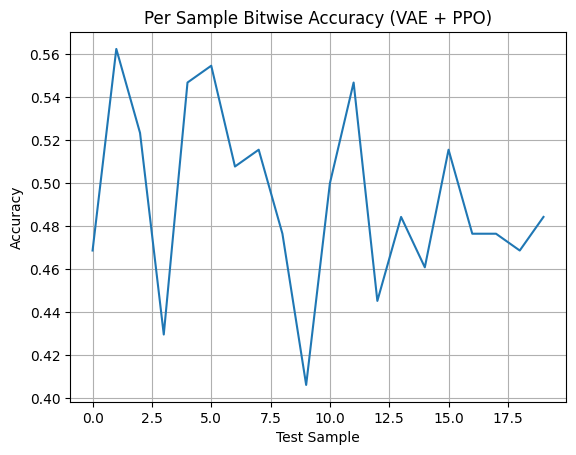

In [47]:
plt.plot(correct_bits)
plt.title("Per Sample Bitwise Accuracy (VAE + PPO)")
plt.xlabel("Test Sample")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
